# Uncertainty-Aware Prediction Validator in Deep Learning Models for Cyber-Physical System Data

## Robot dataset

This repository presents the experiments of the paper:

`Uncertainty-Aware Prediction Validator in Deep Learning Models for Cyber-Physical System Data`

**Importing libraries**

In [ ]:
!pip install -q plot_keras_history
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
from keras.models import Model, Input
from keras.layers import Dropout,Dense
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,\
    precision_score,recall_score,f1_score
import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import norm
import itertools
from keras.callbacks import ModelCheckpoint
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from imblearn.over_sampling import SMOTE
from scipy.stats import entropy
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.transforms as transforms
import tensorflow as tf
from glob import glob

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
np.random.seed(10)

In [ ]:
from google.colab import drive
import uuid
drive.mount("/content/gdrive")
RESULTS_PATH = '/content/gdrive/My Drive/ds/results/'
DS_PATH = '/content/gdrive/My Drive/ds/datasets/robots.zip'
MODEL_FILENAME = '/content/gdrive/My Drive/ds/datasets/robots.hdf5'

Mounted at /content/gdrive


### Dataset preprocessing

In [ ]:
col_names = ['f' + str(i) for i in range(24)]
col_names.append('label')

df = pd.read_csv(DS_PATH, skiprows=0, low_memory=False,names=col_names, compression='zip')
class_names = df.label.unique()
df.sample(10)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,label
3294,1.455,1.477,1.504,5.000,5.000,4.431,1.735,1.725,1.736,2.259,1.782,5.000,1.345,1.336,1.347,1.215,1.395,0.579,0.567,0.558,0.567,4.435,0.646,1.448,Move-Forward
3390,1.111,1.140,2.331,2.331,3.058,5.000,5.000,1.253,5.000,1.199,1.184,1.223,1.429,1.428,5.000,0.622,0.610,0.619,0.636,0.658,1.095,1.079,1.064,1.128,Move-Forward
2469,0.548,1.382,1.378,1.395,5.000,1.454,2.618,2.632,3.252,5.000,5.000,5.000,0.910,0.865,0.862,0.878,1.064,0.494,0.572,0.448,0.448,0.465,0.531,0.805,Sharp-Right-Turn
2534,0.908,0.935,1.631,1.605,1.598,1.608,5.000,2.945,2.357,2.831,2.810,5.000,5.000,5.000,5.000,0.674,0.661,0.662,0.689,1.198,0.907,0.891,0.880,0.890,Move-Forward
3139,1.273,2.418,2.420,2.628,2.645,5.000,3.884,3.260,2.815,2.797,2.824,1.802,3.872,0.954,0.776,0.766,0.774,0.366,0.854,0.819,0.857,0.854,0.862,4.328,Sharp-Right-Turn
606,1.407,1.444,1.458,2.622,3.259,3.252,5.000,5.000,5.000,5.000,0.829,0.825,5.000,5.000,5.000,0.477,0.453,0.454,0.476,0.493,1.418,1.404,1.384,1.392,Sharp-Right-Turn
1453,0.806,1.486,2.744,2.756,5.000,5.000,5.000,5.000,1.470,1.457,1.506,2.613,5.000,5.000,0.794,0.783,0.792,0.808,1.151,1.221,0.767,0.759,0.765,0.789,Sharp-Right-Turn
3396,1.272,1.518,2.423,2.423,3.115,3.176,5.000,1.132,5.000,1.081,1.066,1.071,1.308,1.311,2.057,0.582,0.569,0.580,0.592,0.616,1.213,1.196,1.181,1.206,Move-Forward
4705,1.089,1.680,1.671,1.681,1.616,3.142,5.000,3.990,5.000,1.932,1.902,1.856,1.784,1.118,5.000,0.658,0.562,0.562,0.579,0.604,0.934,1.304,1.089,1.077,Move-Forward
311,2.325,2.541,5.000,2.073,2.428,3.849,4.263,2.812,3.015,3.013,3.856,0.901,0.879,0.864,0.878,0.452,0.896,0.779,1.247,0.839,5.000,4.260,5.000,1.758,Sharp-Right-Turn


In [ ]:
y = df.label.values
y = LabelBinarizer().fit_transform(y)
df.drop(["label"], axis=1, inplace=True)

X = df.values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33)

## Bayesian Neural Network and Monte Carlo Dropout methods definitions

In [ ]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)

def shannon_entropy(vals):
    return -1*np.sum([ val*np.log2(val+0.000000000001) for val in vals])

def get_model(mc=False, act="relu", dropout_size=0.3, num_of_class=2, input_size=2):
    inp = Input(input_size, name='main_input')
    x = Dense(100, activation=act,name='Layer-1')(inp)
    x = get_dropout(x, p=dropout_size, mc=mc)
    x = Dense(200, activation=act,name='Layer-2')(x)
    x = get_dropout(x, p=dropout_size, mc=mc)
    x = Dense(100, activation=act,name='Layer-3')(x)
    x = get_dropout(x, p=dropout_size, mc=mc)
    out = Dense(num_of_class, activation='softmax',name='Output-layer')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy",
                  optimizer="rmsprop",
                  metrics=['accuracy'])

    return model

In [ ]:
def train_models_without_dropouts(model, update_dropouts=True):
    dropout_layers = [2, 4, 6]
    initial_rate = model.layers[dropout_layers[0]].rate
    
    # change dropout ratio to 0
    # i.e. disable dropouts for training
    if update_dropouts:
      for layer_idx in dropout_layers:
          model.layers[layer_idx].rate = 0.0
        
    model.compile(loss="categorical_crossentropy",
                  optimizer="rmsprop",
                  metrics=['accuracy'])
    
    mcp_save = ModelCheckpoint(MODEL_FILENAME, save_best_only=True, 
                               monitor='val_accuracy', mode='max')
    
    es = EarlyStopping(monitor='val_accuracy', 
                       patience=10, 
                       min_delta=0.001,
                       verbose=0,
                       restore_best_weights=True,
                       mode='max')
    
    history_mc = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epoch_size,
              callbacks=[mcp_save,es],
              verbose=0,
              validation_data=(X_test, y_test))
    
    # change dropout ratio to original value
    # i.e. enable dropouts for prediction
    if update_dropouts:
      for layer_idx in dropout_layers:
          model.layers[layer_idx].rate = initial_rate
    
    model.compile(loss="categorical_crossentropy",
                  optimizer="rmsprop",
                  metrics=['accuracy'])

    return model, history_mc

## Neural Network model training

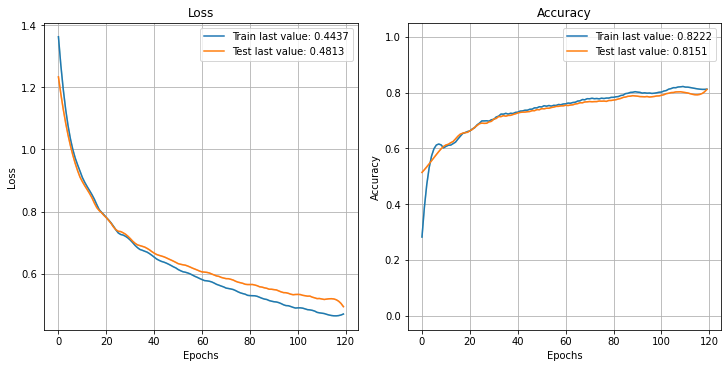

In [ ]:
epoch_size = 20000
batch_size = 10000

pred_model_mc = get_model(mc=True, 
                          num_of_class=4, 
                          dropout_size=0.02,
                          input_size=X.shape[1],
                          act="relu")

pred_model_mc, history_mc = train_models_without_dropouts(pred_model_mc)

plot_history(history_mc.history, interpolate=True)
plt.show()

## Let's find the uncertainty values of the each test dataset

In [ ]:
# Monte carlo predictions
mc_predictions = []
for i in tqdm.tqdm(range(200)):
    y_p = pred_model_mc.predict(X_test, batch_size=1000)
    mc_predictions.append(y_p)

max_means = []
preds = []
entropy_vals = []
std_vals = []
for idx in range(X_test.shape[0]):
    px = np.array([p[idx] for p in mc_predictions])
    #print(px.max(axis=1))
    preds.append(px.mean(axis=0).argmax())
    max_means.append(px.mean(axis=0).max())
    prob_dist = []
    for i, (prob, var) in enumerate(zip(px.mean(axis=0), px.std(axis=0))):
        prob_dist.append(prob)
    entropy_vals.append(shannon_entropy(prob_dist))
    #entropy_vals.append(entropy(prob_dist, base=2))
    std_vals.append(np.std(px.max(axis=1)))

unc_ent_idx = np.flip((np.array(entropy_vals)).argsort()[-3:])
unc_std_idx = np.flip((np.array(std_vals)).argsort()[0:3])

100%|██████████| 200/200 [00:11<00:00, 17.93it/s]


## Research Questions
We aim to explore uncertainty quantification using the Bayesian neural network with the entropy and Softmax prediction probability variance methods. So we form the following Research Questions (RQs) and design the experiments to answer them: 

- **RQ0** Is there any correlation between uncertainty and prediction performance? 
- **RQ1** How can a model's decision making be characterized with uncertainty quantification? 
- **RQ2** How can a model's false labelling be predicted by another model benefiting from uncertainty values (obtained from RQ1)? 
- **RQ3** What is the best dropout ratio for uncertainty quantification for each dataset? 
- **RQ4** Can we improve the prediction performance of the DL models by using highly uncertain instances (obtained from RQ1) in the retraining of the models? 

### RQ0: Is there any correlation between uncertainty and classification performance?

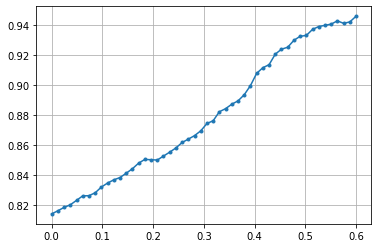

In [ ]:
df_results = pd.DataFrame(data = X_test,
                  columns=['f' + str(i) for i in range(X_test.shape[1])])
df_results['y'] = y_test.argmax(axis=1)
df_results['y_hat'] = preds
df_results['unc_entropy'] = entropy_vals
df_results['unc_std'] = std_vals

discarded_ratio_list = np.linspace(0,0.6,num=50)

df_results.sort_values(by=['unc_entropy'],ascending=True,inplace=True)

acc_list = []
for discarded_ratio in discarded_ratio_list:
    tmp_df = df_results.head(np.int(df_results.shape[0] * (1-discarded_ratio)))
    y = tmp_df.y.values
    y_hat = tmp_df.y_hat.values
    acc_list.append(accuracy_score(y,y_hat))
plt.plot(discarded_ratio_list,acc_list, '-', marker = '.')
plt.grid()
plt.show()

### RQ1: How can a model's decision making be characterized with uncertainty quantification?

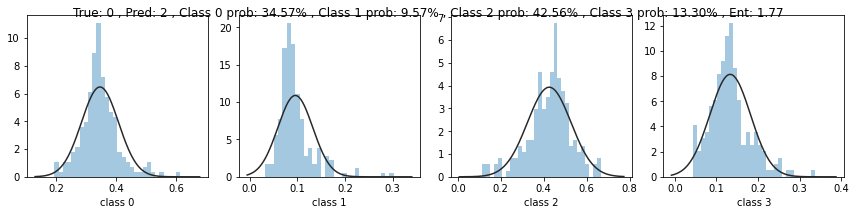

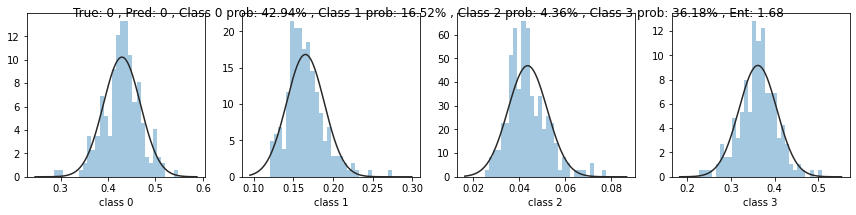

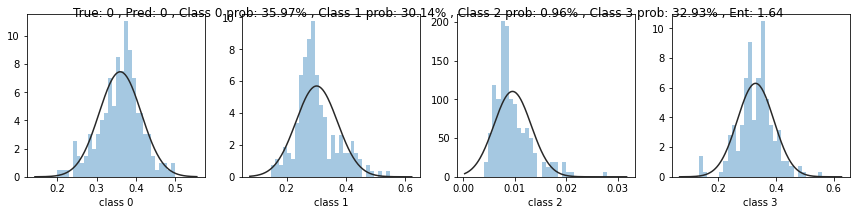

In [ ]:
for idx_iter in range(3):
    idx = unc_ent_idx[idx_iter]
    p0 = np.array([p[idx] for p in mc_predictions])
    prob_txt = []
    prob_txt.append("True: {}".format(y_test[idx].argmax()))
    prob_txt.append(", Pred: {}".format(p0.mean(axis=0).argmax()))

    prob_dist = []

    for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
        prob_txt.append(", Class {} prob: {:2.2f}%".format(i, prob*100))
        prob_dist.append(prob)
    prob_txt.append(", Ent: {:.2f}".format(shannon_entropy(prob_dist)))

    prob_txt = " ".join(prob_txt).strip()
    fig, axes = plt.subplots(1, 4, figsize=(12,3))

    for i, ax in enumerate(fig.get_axes()):
        #print(p0[:,i])
        sns.distplot( p0[:,i],ax=ax, bins=30, fit=norm, kde=False)
        ax.set_xlabel(f"class {i}")

    fig.suptitle(prob_txt)
    fig.tight_layout()
    
    plt.show()

### RQ2: How can a model's false labelling be predicted by another model benefiting from uncertainty values (obtained from RQ1)?

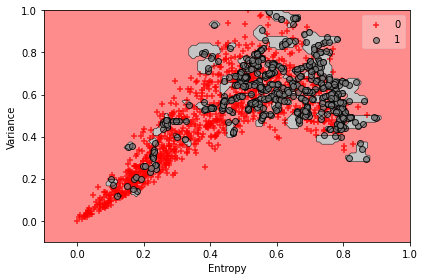

In [ ]:
oversample = SMOTE(sampling_strategy=0.5, random_state=10)

X_unc = np.stack((entropy_vals,std_vals),axis=1)
scaler = MinMaxScaler()
X_unc = scaler.fit_transform(X_unc)

mc_ensemble_pred = np.array(mc_predictions).mean(axis=0).argmax(axis=1)
wrong_labels = np.abs(y_test.argmax(axis=1) - mc_ensemble_pred)
wrong_labels[np.where(wrong_labels > 0)] = 1

X_w_train, X_w_test, y_w_train, y_w_test = train_test_split(X_unc, wrong_labels, 
                                                    test_size=0.3)

X_w_train, y_w_train = oversample.fit_resample(X_w_train, y_w_train)

clf = SVC(gamma=1000,kernel='rbf',C=1000,tol=1e-14, max_iter=1e8)
clf.fit(X_w_train, y_w_train)

ax = plot_decision_regions(X_w_train, y_w_train, clf=clf, legend=1,
                      markers='+o',hide_spines=False,colors='red,gray')
plt.xlim((-0.1,1.0))
plt.ylim((-0.1,1.0))
plt.xlabel('Entropy')
plt.ylabel('Variance')
plt.tight_layout()
plt.show()

### RQ3: What is the best strategy for the best dropout ratio?

In [ ]:
def get_model_pref(dropout_ratio):
    
    model = get_model(mc=True, 
                      num_of_class=4, 
                      dropout_size=dropout_ratio,
                      input_size=X.shape[1],
                      act="relu")

    model, history_mc = train_models_without_dropouts(model, update_dropouts=False)
    
    '''
    dropout_layers = [2, 4, 6]
    model = tf.keras.models.load_model(MODEL_FILENAME)
    
    for layer_idx in dropout_layers:
        model.layers[layer_idx].rate = dropout_ratio
    '''  
    model.compile(loss="categorical_crossentropy",
                  optimizer="rmsprop",
                  metrics=['accuracy'])
    
    mc_predictions = []
    for i in range(100):
        y_p = model.predict(X_test, batch_size=1000)
        mc_predictions.append(y_p)
        
    max_means = []
    preds = []
    entropy_vals = []
    std_vals = []
    for idx in range(X_test.shape[0]):
        px = np.array([p[idx] for p in mc_predictions])
        preds.append(px.mean(axis=0).argmax())
        max_means.append(px.mean(axis=0).max())

        prob_dist = []
        for i, (prob, var) in enumerate(zip(px.mean(axis=0), px.std(axis=0))):
            prob_dist.append(prob)
        entropy_vals.append(shannon_entropy(prob_dist))
        std_vals.append(np.std(preds))
    
    df_results = pd.DataFrame({'y': y_test.argmax(axis=1), 'y_hat': preds, 
                               'uncertainty': entropy_vals, 'unc_std':std_vals})
    
    # The total uncertainty value for correct predictions
    correct_unc = np.mean(df_results.query('y == y_hat').uncertainty.values)
    # The total uncertainty value for incorrect predictions
    incorrect_unc = np.mean(df_results.query('y != y_hat').uncertainty.values)
    
    f1 = f1_score(y_test.argmax(axis=1),preds,average='weighted')
    
    df_results_overview = pd.DataFrame({'p':dropout_ratio,
                                        'avg_unc_corr':correct_unc,
                                        'avg_unc_incorr':incorrect_unc,
                                        'f1':f1}, index=[0])
    df_results_overview["best"] = df_results_overview.apply(lambda row: row['avg_unc_corr'] + 1.0/row['avg_unc_incorr']+ 1.0/row['f1'], axis=1)
    return df_results_overview

In [ ]:
# Perform 50 experiments to find the best dropout ratio
from tqdm.notebook import tqdm
dropout_rates = np.linspace(0.0, 0.9, num=50, endpoint=True).round(2)
epoch_size = 20000
batch_size = 10000
df_list = []

for test_iter_no in tqdm(range(50)):
    df_experiment_list = []
    avg_unc_rate = []
    avg_unc_rate_corr = []
    avg_unc_rate_corr_size = []
    avg_unc_rate_incorr = []
    avg_unc_rate_incorr_size = []
    
    for do_rate in dropout_rates:
        tmp_df = get_model_pref(do_rate)
        df_list.append(tmp_df)
        df_experiment_list.append(tmp_df)
    df_experiment_list = pd.concat(df_experiment_list, ignore_index=True)
    df_experiment_list.to_csv(RESULTS_PATH + 'robot-' + str(uuid.uuid4()) + '.csv', index=False)
result_df = pd.concat(df_list, ignore_index=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
### load existing experiment results
df_list = []
res_files = glob(RESULTS_PATH + 'robot*.csv')
for res_file in res_files:
  tmp_df = pd.read_csv(res_file)
  df_list.append(tmp_df)
result_df = pd.concat(df_list, ignore_index=True)

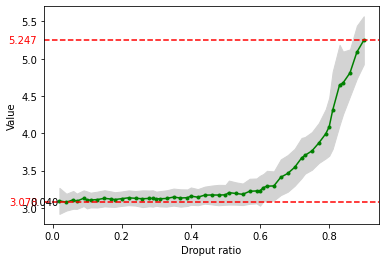

In [ ]:
# plot the results
result_df = result_df.query('p > 0.0')
results_avg = result_df.groupby(['p'], as_index=False).mean()
results_std = result_df.groupby(['p'], as_index=False).std()
results_avg.sort_values(by=['p'],inplace=True)

best_avg = results_avg.best.values
best_std = results_std.best.values
p_values = results_avg.p.values

min_p_idx = np.argmin(best_avg)
max_p_idx = np.argmax(best_avg)

ax = plt.axes()
ax.plot(p_values,best_avg, 'go-', markersize=3)
ax.fill_between(p_values, best_avg-best_std, best_avg+best_std, color='lightgray')

ax.set_xlabel('Droput ratio')
ax.set_ylabel('Value')

plt.axhline(y=best_avg[min_p_idx], color='r', linestyle='--')
plt.axhline(y=best_avg[max_p_idx], color='r', linestyle='--')
#plt.axvline(x=p_values[min_p_idx], color='r', linestyle='--')

trans = transforms.blended_transform_factory(
        ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0,best_avg[max_p_idx], "{:.3f}".format(best_avg[max_p_idx]), 
            color="red", transform=trans,  ha="right", va="center")
ax.text(0,best_avg[min_p_idx], "{:.3f}".format(best_avg[min_p_idx]), 
        color="red", transform=trans,  ha="right", va="center")

ax.text(p_values[min_p_idx]*1.6,best_avg[min_p_idx], "{:.3f}".format(p_values[min_p_idx]), 
        color="black", transform=trans,  ha="right", va="center")
    
plt.show()

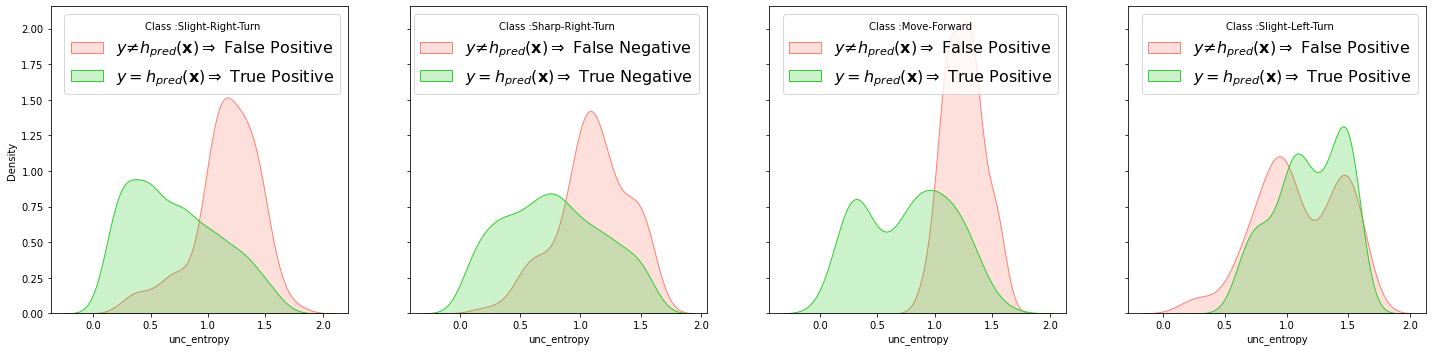

In [ ]:
num_of_class = 4
fig, axes = plt.subplots(1, num_of_class, figsize=(20, 5), sharey=True)
for i in range(num_of_class):
    kde_plot_title = ' Positive'
    if i == 1:
        kde_plot_title = ' Negative'

    subset = df_results.query('y==' + str(i) + ' and y_hat!=' + str(i))
    sns.distplot(subset['unc_entropy'], hist = False, kde = True,
                 kde_kws = {'linewidth': 1, 'shade': True},ax=axes[i],
                 hist_kws=dict(alpha=1),color="salmon",
                 label = r'$y \ne h_{pred}(\mathbf{x}) \Rightarrow$ False' + kde_plot_title)
    
    subset = df_results.query('y==' + str(i) + ' and y_hat==' + str(i))
    sns.distplot( subset['unc_entropy'], hist = False, kde = True,
                 kde_kws = {'linewidth': 1, 'shade': True},ax=axes[i],
                 hist_kws=dict(alpha=1),color="limegreen",
                 label = '$y = h_{pred}(\mathbf{x}) \Rightarrow$ True' + kde_plot_title)
    axes[i].legend(prop={'size': 16}, 
                           title = 'Class :' + class_names[i])
plt.tight_layout()
plt.show()